# DNN: analyse data with Keras 

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as opt

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# plt.reParams['font.size'] = 14

%run nonlinear_function.py

# training data
perc_train = 0.8

# data augmentation
augment_data = False
aug_amount = 3200
shift = 0.1

# save training data (loss, accuracy) in a csv file
save_csv = False

L = 2

[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 1.0

data: 4000


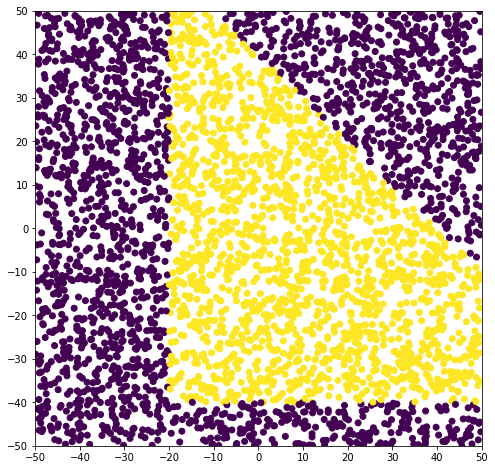

In [2]:
# Keras works with numpy arrays: just use them from the start
TYPE = 1
x = np.loadtxt(filename("data", TYPE), delimiter=' ')
y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
N = len(x)

# dim of a sample
L = len(x[0])
print('L =', L)

print('')
for i in range(10):
    print(x[i], y[i])

print(f'\ndata: {N}')

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

## Split training and test data

In [3]:
N_train = int(perc_train * N)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]
print('Train:', len(x_train), '\t Validation:', len(x_valid))

Train: 3200 	 Validation: 800


## Rescale input data

In [4]:
def Rescale(x):
    # return (x-x.mean())/np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

## Data augmentation

In [5]:
if augment_data:
    # augmentation is applied only on training data (not on the validation set!)

    theta = np.random.randint(0, 2*np.pi, aug_amount) # shift each selected point in a random direction
    mask = np.random.choice(x_train.shape[0], aug_amount, replace=False)

    x_aug = x_train[mask]+shift*np.vstack((np.cos(theta), np.sin(theta))).T
    y_aug = y_train[mask]

    x_train = np.vstack((x_train, x_aug))
    y_train = np.hstack((y_train, y_aug))  

    print('training data:', x_train.shape[0])


training data: 6400


## Define the model with Keras

In [6]:
# reproducibility
np.random.seed(12345) # maybe not useful (Keras has is own initialization..)

# sequential model
CASE=1

if CASE==1:
    model=Sequential()
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    nepoch=400
    batch_size=50

if CASE==2:
    model=Sequential()
    model.add(Dense(L, input_shape=(L,), activation='sigmoid'))
    model.add(Dense(3, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    nepoch=400
    batch_size=50
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


## Optimization method and cost function

In [7]:
model.compile(loss='binary_crossentropy', 
              #optimizer='RMSprop',
              optimizer='adam', 
              metrics=['accuracy'])

## Training

In [8]:
fit = model.fit(x_train, y_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x_valid, y_valid), 
                verbose=1)

Epoch 1/400
128/128 [==============================] - 1s 2ms/step - loss: 0.6103 - accuracy: 0.6481 - val_loss: 0.5738 - val_accuracy: 0.6363
Epoch 2/400
128/128 [==============================] - 0s 1ms/step - loss: 0.5302 - accuracy: 0.6972 - val_loss: 0.5234 - val_accuracy: 0.6538
Epoch 3/400
128/128 [==============================] - 0s 1ms/step - loss: 0.4878 - accuracy: 0.7348 - val_loss: 0.4738 - val_accuracy: 0.7550
Epoch 4/400
128/128 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.7802 - val_loss: 0.4225 - val_accuracy: 0.7962
Epoch 5/400
128/128 [==============================] - 0s 1ms/step - loss: 0.4027 - accuracy: 0.8159 - val_loss: 0.3601 - val_accuracy: 0.8512
Epoch 6/400
128/128 [==============================] - 0s 1ms/step - loss: 0.3513 - accuracy: 0.8444 - val_loss: 0.3051 - val_accuracy: 0.8737
Epoch 7/400
128/128 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.8742 - val_loss: 0.2450 - val_accuracy: 0.9062

In [9]:
print('Training error: %.4f' %fit.history['loss'][-1])
print('Validation error: %.4f' %fit.history['val_loss'][-1])


Training error: 0.1193
Validation error: 0.0646


## Save training data in a .csv file

In [10]:
if save_csv: 
    import csv

    training_data = np.column_stack((fit.history['accuracy'], fit.history['val_accuracy'], fit.history['loss'], fit.history['val_loss']))

    if augment_data: 
        filename = 'TrainingData/training_Augmented.csv'
    else:
        filename = 'TrainingData/training_'+str(N)+'.csv'
    header = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(header)
        writer.writerows(training_data)


## Plot

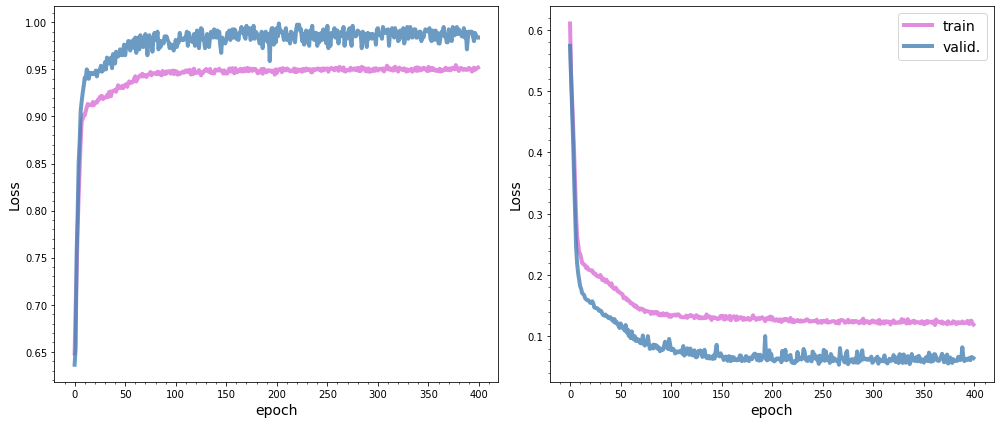

In [11]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(fit.history['accuracy'], linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit.history['val_accuracy'], linewidth=4, color='steelblue', alpha=0.8)

ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")

ax=AX[1]
ax.plot(fit.history['loss'],label="train", linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit.history['val_loss'],label="valid.", linewidth=4, color='steelblue', alpha=0.8)


ax.legend(loc="upper right", fontsize=14)


for i in AX:
    i.minorticks_on()
    i.set_xlabel('epoch', fontsize=14)
    i.set_ylabel("Loss", fontsize=14)
fig.tight_layout()




In [12]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]


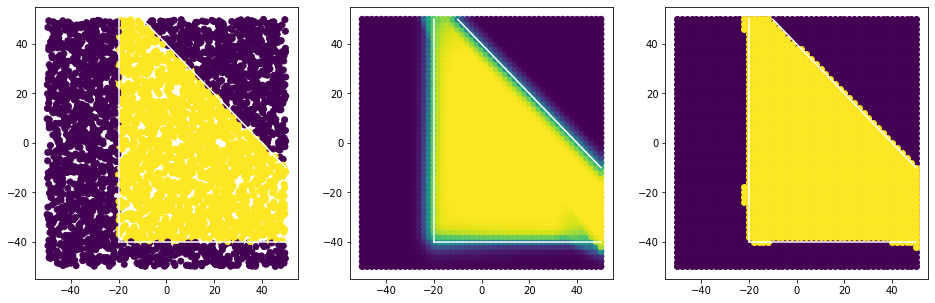

In [13]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
    
fig,AX = plt.subplots(1,3,figsize=(16,5.))

ax=AX[0]
ax.scatter(x[:,0],x[:,1], c=y)
boundaries()

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
boundaries()

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

plt.show()

## Multiple plot from files (different N)

In [14]:
import pandas as pd

folder_name = 'TrainingData'
file_names = ['training_2000.csv', 'training_4000.csv', 'training_6000.csv']
file_paths = [folder_name+"/"+name for name in file_names]

df_dic={'N='+path[len(folder_name)+10:-4]: pd.read_csv(path) for path in file_paths}
print('Dataframes available: ', [i for i in df_dic.keys()])

Dataframes available:  ['N=2000', 'N=4000', 'N=6000']


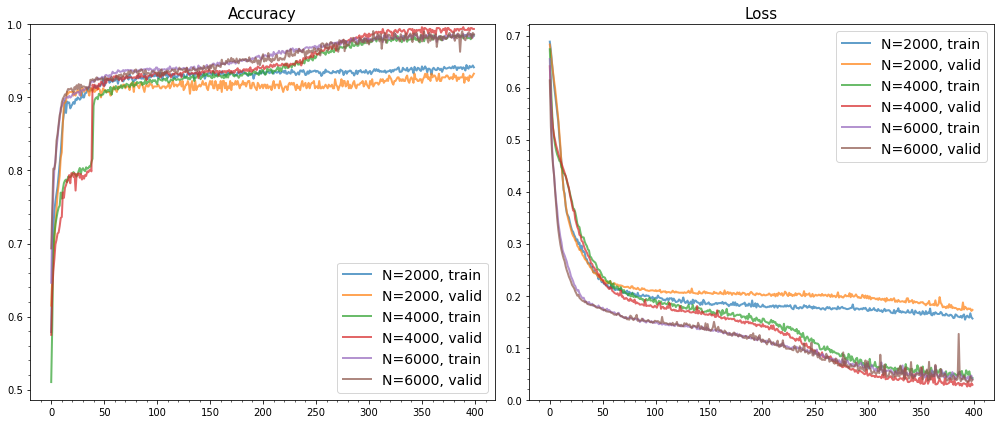

In [15]:
fig,(ax0, ax1) = plt.subplots(1,2,figsize=(14,6.))

for key in df_dic:
    ax0.plot(df_dic[key]['accuracy'], label=key+", train", linewidth=2, alpha=0.7)
    ax0.plot(df_dic[key]['val_accuracy'], label=key+", valid", linewidth=2, alpha=0.7)
    ax1.plot(df_dic[key]['loss'],label=key+", train", linewidth=2, alpha=0.7)
    ax1.plot(df_dic[key]['val_loss'],label=key+", valid", linewidth=2, alpha=0.7)
    
ax0.minorticks_on()
# ax0.set_xlabel('epoch', fontsize=14)
# ax0.set_ylabel("Accuracy", fontsize=14)
ax0.set_title("Accuracy", fontsize=15)
ax0.set_ylim(top=1)
ax0.legend(loc="lower right", fontsize=14)

ax1.minorticks_on()
# ax1.set_xlabel('epoch', fontsize=14)
# ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Loss", fontsize=15)
ax1.set_ylim(bottom=0)
ax1.legend(loc="upper right", fontsize=14)

fig.tight_layout()
plt.show()


## Grid search

In [16]:
# compile a specified model with a particular optimizer
# useful for GridSearchCV
def compile_model(optimizer, activation, dropout, layer_size):

    # create the model
    model = Sequential()

    # add architecture specs
    # first layer
    model.add(Dense(layer_size[0], input_shape=(L,), activation=activation))

    # deeper layers
    for lyr_sz in layer_size[1:]:
        model.add(Dense(lyr_sz, activation=activation))

    # dropout rate
    model.add(Dropout(dropout))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])


    return model                



# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=0)

# list of allowed optional arguments for the optimizer
nesterov = opt.SGD(nesterov=True)
#optimizer = ['Adam', 'RMSprop', 'SGD', nesterov]

optimizer= ['Adam', 'RMSprop']
activation = ['sigmoid', 'relu']
#activation = ['sigmoid', 'relu', 'elu', 'tanh']
dropout = [0.1, 0.2, 0.4]
layer_size = [(50,50,), (20,20,)]
# Ho aggiunto il primo layer con due neuroni così ha la
#stessa profondità del network di Baiesi


# define parameter dictionary
param_grid = {'optimizer': optimizer,
              'activation': activation,
              'dropout': dropout,
              'layer_size': layer_size
              }

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

<ipython-input-16-06d316a21088>:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model,


In [17]:
# summarize results
display(pd.DataFrame.from_dict(grid_result.cv_results_).loc[:,["params","mean_test_score"]])

print("\n\nBest parameters set found:")
print(grid_result.best_params_)

print("\nScore with best parameters:")
print(grid_result.best_score_)

,params,mean_test_score
0,"{'activation': 'sigmoid', 'dropout': 0.1, 'lay...",0.566562
1,"{'activation': 'sigmoid', 'dropout': 0.1, 'lay...",0.582656
2,"{'activation': 'sigmoid', 'dropout': 0.1, 'lay...",0.534063
3,"{'activation': 'sigmoid', 'dropout': 0.1, 'lay...",0.536719
4,"{'activation': 'sigmoid', 'dropout': 0.2, 'lay...",0.537500
5,"{'activation': 'sigmoid', 'dropout': 0.2, 'lay...",0.549375
6,"{'activation': 'sigmoid', 'dropout': 0.2, 'lay...",0.537500
7,"{'activation': 'sigmoid', 'dropout': 0.2, 'lay...",0.539375
8,"{'activation': 'sigmoid', 'dropout': 0.4, 'lay...",0.550938
9,"{'activation': 'sigmoid', 'dropout': 0.4, 'lay...",0.536094




Best parameters set found:
{'activation': 'relu', 'dropout': 0.2, 'layer_size': (50, 50), 'optimizer': 'RMSprop'}

Score with best parameters:
0.7837499976158142


In [18]:
# in order to do cross validation on the learning rate on the best algorithm found
#tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,  epsilon=1e-07, amsgrad=False, name="Adam", **kwargs)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68aafe1b-040f-4657-bf91-52c6a793f99c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>